In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import neurokit2 as nk
from scipy.optimize import least_squares
from scipy.signal import spectrogram
import copy

In [2]:
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)

In [3]:
T_c = 91.72 * (1e-6)   # Chirp time
SAMPLE_PER_CHIRP = 256
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
speed_of_light = 300000000
NUMBER_OF_CHANNEL=4
FPS=20 #20 frame/s
CHIRP_PER_FRAME=2 # 2 chirp/ frame
DURATION=5#minute
FRAME_COUNT = DURATION * 60 * FPS
SAMPLE_PER_FRAME = CHIRP_PER_FRAME *SAMPLE_PER_CHIRP
FFT_SIZE=2**9
RANGE_RESOLUTION =float(speed_of_light)/(2*B)
SAMPLING_RATE = 3000e3;
FREQ_SLOPE =40.8450012207031251e6*1e6
RANGE_BIN =(float(speed_of_light) * SAMPLING_RATE) / (2*FREQ_SLOPE*FFT_SIZE) ;

MAX_RANGE =(SAMPLING_RATE *speed_of_light)/(2*FREQ_SLOPE);

print("Number of frame: {0}".format(FRAME_COUNT))
print("Number of sample per frame: {0}".format(SAMPLE_PER_FRAME))
print("FFT size {0}".format(FFT_SIZE))
print("Range resolution {0}".format(RANGE_RESOLUTION))
print("Range bin {0}".format(RANGE_BIN))
print("Max range {0}".format(MAX_RANGE))

Number of frame: 6000
Number of sample per frame: 512
FFT size 512
Range resolution 0.04
Range bin 0.021518086026020445
Max range 11.017260045322468


In [4]:
#read data
file_path = '../FMCW Radar/Rawdata/Rawdata_7.csv'
raw_data = readCsv(file_path)

In [5]:
RawData4Channel=np.array(raw_data).reshape(NUMBER_OF_CHANNEL,FRAME_COUNT,SAMPLE_PER_FRAME)

In [6]:
data_channel_0=RawData4Channel[0]
data_channel_1=RawData4Channel[1]
data_channel_2=RawData4Channel[2]
data_channel_3=RawData4Channel[3]

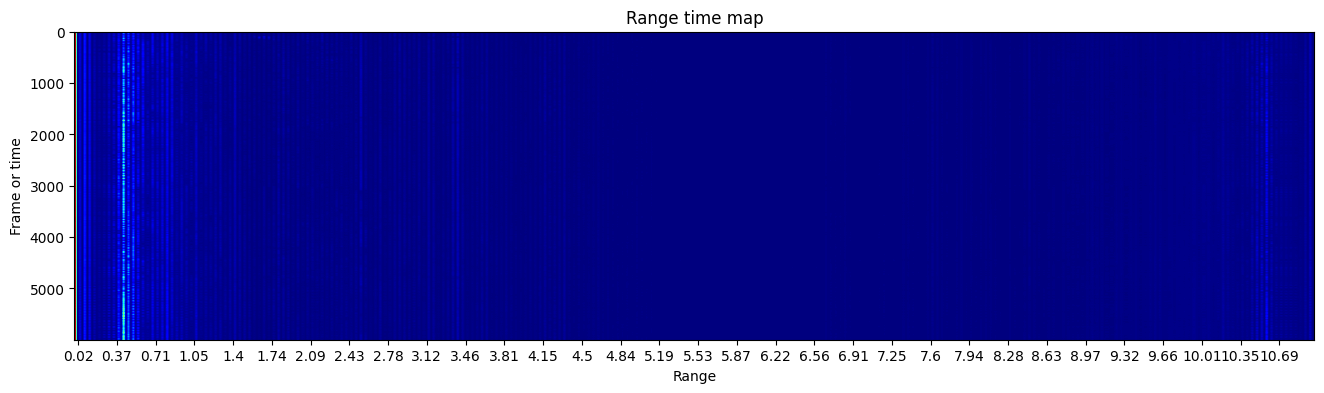

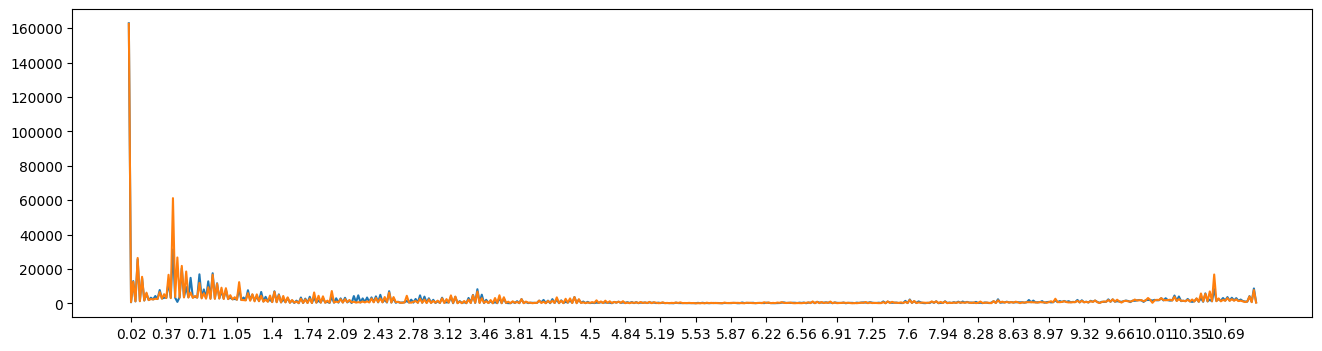

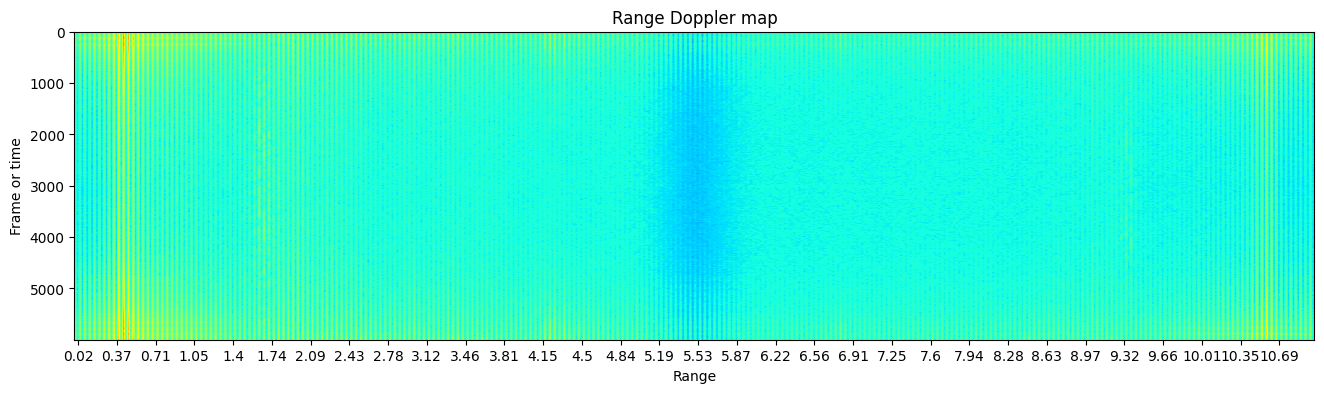

In [7]:
est_channel=data_channel_0
range_for_plotting =range(1,FFT_SIZE,2**4)
range_bin_distance =[round(j*RANGE_BIN,2) for j in range_for_plotting ]

range_fft_channel_0=np.fft.fft(est_channel,FFT_SIZE,axis=1)
doppler_fft_channel_0=np.fft.fft2(est_channel)
mag_range_fft_channel_0=np.abs(range_fft_channel_0)
mag_doppler_fft_channel_0=np.log(np.abs(doppler_fft_channel_0))

plt.figure(figsize=(16,4))
plt.xlabel('Range')
plt.ylabel('Frame or time')
plt.title("Range time map")
plt.imshow(mag_range_fft_channel_0,cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.show()

plt.figure(figsize=(16,4))
plt.plot(mag_range_fft_channel_0[0])
plt.plot(mag_range_fft_channel_0[-1])
plt.xticks(range_for_plotting, range_bin_distance)
plt.show()

column=range_fft_channel_0.shape[1]
colum_FFT_range_fft_channel_0=np.zeros_like(range_fft_channel_0)
for c in range(0,column):
    colum_FFT_range_fft_channel_0[:,c] =np.fft.fft(range_fft_channel_0[:,c])

plt.figure(figsize=(16,4))
plt.xlabel('Range')
plt.ylabel('Frame or time')
plt.title("Range Doppler map")
plt.imshow(np.log(np.abs(colum_FFT_range_fft_channel_0)),cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.show()


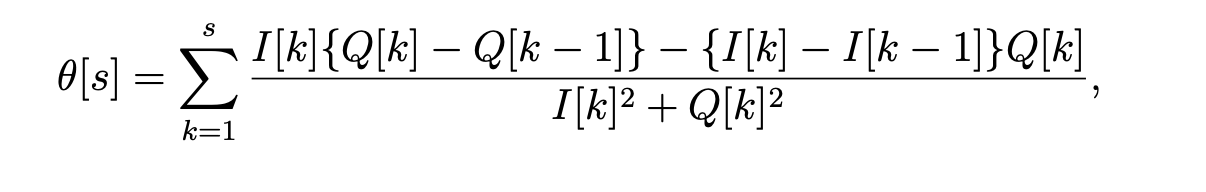


In [33]:
def extract_phase_DACM(complex_signals):
    phases=[]
    phases.append(np.angle(complex_signals[0]))

    for s in range(1,len(complex_signals)):
        phase_s=0
        for k in range(1,s):
            I_k =complex_signals[k].real
            Q_k=complex_signals[k].imag
            I_k_1=complex_signals[k-1].real
            Q_k_1=complex_signals[k-1].imag
            phase_s+=(I_k*(Q_k-Q_k_1) - (I_k -I_k_1)*Q_k)/(I_k**2 +Q_k**2)
        phases.append(phase_s)
    return phases


In [9]:
#method 1: find the peak of i and Q
m1_peak=[]
for chirp in est_channel:
    found_peak =chirp[0]
    for sample in chirp:
        if(np.abs(sample) > np.abs(found_peak)):
            found_peak =sample
    m1_peak.append(found_peak)


In [36]:
dacm_phase=extract_phase_DACM(m1_peak)
unwrap_phase =np.unwrap(np.angle(m1_peak))


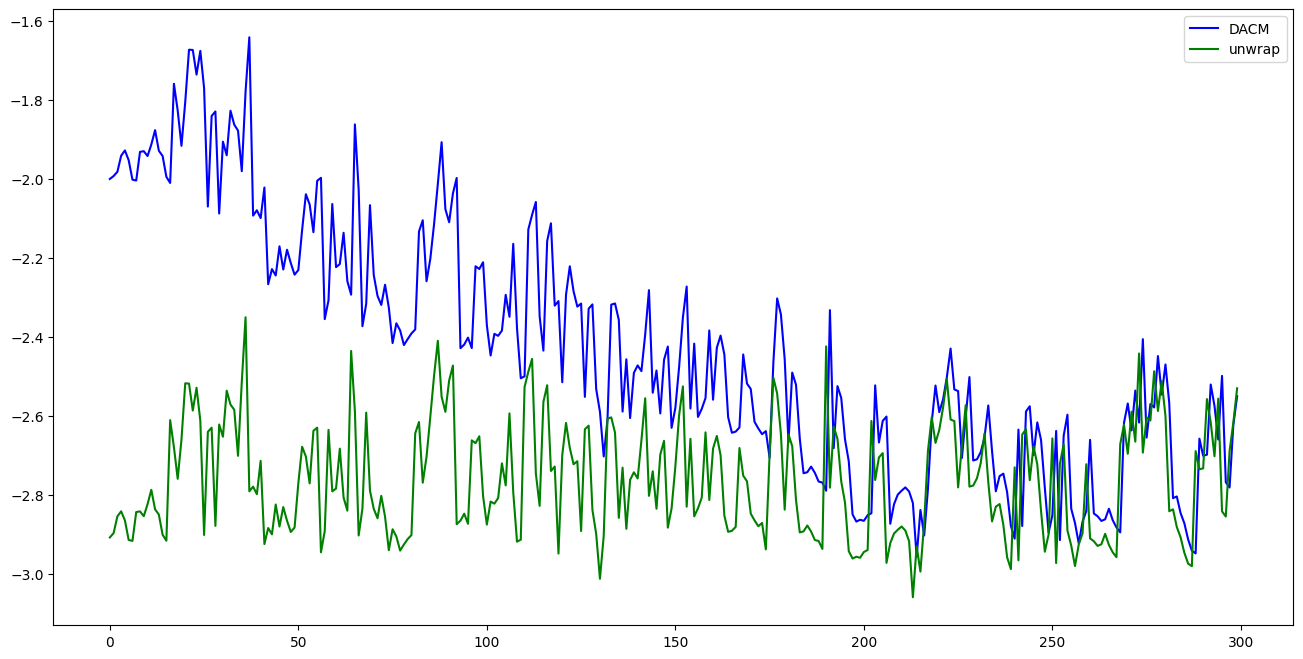

In [39]:
plt.figure(figsize=(16,8))
plt.plot(dacm_phase[900:1200],label="DACM",color="blue")
plt.plot(unwrap_phase[900:1200],label="unwrap",color="green")
plt.legend()
plt.show()

In [40]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

In [ ]:
EXTRACTED_SAMPLING_RATE=40
breath_heart_band_filtering=[20/60,120/60]
DACMfiltered_signal =filter_signal(np.array(est_signal_DACM),breath_heart_band_filtering[0],breath_heart_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

breath_band_filtering=[20/60,60/60]
DACMbreath_filtered_signal =filter_signal(np.array(est_signal_DACM),breath_band_filtering[0],breath_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

heart_band_filtering=[80/60,120/60]
DACMheart_filtered_signal =filter_signal(np.array(est_signal_DACM),heart_band_filtering[0],heart_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)